# Summary



The mini-project consists of two components:

Basic solution : Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.

Advanced solution :Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model to identify a numeral in a short sequence


# Environment Setup

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

# Data download

In this section we will download the data that you need to build your solutions. Note that even though we call it "training" dataset you can do whatever you want with it, for instance validation tasks. Note that we keep a separate dataset for testing purposes, which we won't share with anyone.

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
def download_url(url, save_path):
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

The next step is to download the file 'training.zip' into the folder 'MyDrive/Data/MLEnd'. Note that this might take a while.

In [ ]:
url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
download_url(url, save_path)

KeyboardInterrupt: ignored

Finally, let's unzip the training file.

In [ ]:
directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
with zipfile.ZipFile(save_path, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

BadZipFile: ignored

# Data Process

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)

20000

In [ ]:
labels = pd.read_csv('MLEnd/trainingMLEnd.csv')
labels.loc[:,"intonation"].drop_duplicates()

0    question
1     excited
2     neutral
3       bored
Name: intonation, dtype: object

Data processing and generate input and output data x and y

In [ ]:
def getXy(files,labels_file,cls2label):
  X,y =[],[]
  for file in tqdm(files):
    xi = list()
    fileID = file.split('/')[-1]
    yi = cls2label[list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]]
    fs = None
    x, fs = librosa.load(file,sr=fs)
    chroma_stft = librosa.feature.chroma_stft(x, fs) # Chromaticity frequency
    rmse = librosa.feature.rms(x) # calculate rmse
    spec_cent = librosa.feature.spectral_centroid(x, fs) # Calculate the spectral centroid of each frame of audio signal
    spec_bw = librosa.feature.spectral_bandwidth(x, fs) # Calculate the spectral width of each frame of audio signal
    rolloff = librosa.feature.spectral_rolloff(x, fs) # Sound spectrum attenuation Spectral Roll-off It is a measure of signal shape
    zcr = librosa.feature.zero_crossing_rate(x) # Zero Crossing Rate,ZCR refers to the number of times the voice signal passes through the zero point in each frame
    mfcc = librosa.feature.mfcc(x, fs) # Mel frequency cepstrum coefficient, MFCC is a small group of characteristics (usually about 10-20),It concisely describes the overall shape of the spectrum envelope, and it simulates the characteristics of the human voice.
    xi.append(np.mean(chroma_stft))
    xi.append(np.mean(rmse))
    xi.append(np.mean(spec_cent))
    xi.append(np.mean(spec_bw))
    xi.append(np.mean(rolloff))
    xi.append(np.mean(zcr))
    for feature in mfcc:
      xi.append(np.mean(feature))
    X.append(xi)
    y.append(yi)
  return np.array(X),np.array(y)

In [ ]:
cls2label = dict(zip(labels.loc[:,"intonation"].drop_duplicates().values,list(range(len(labels.loc[:,"intonation"].drop_duplicates())))))
cls2label

{'question': 0, 'excited': 1, 'neutral': 2, 'bored': 3}

In [ ]:
X,y = getXy(files,labels,cls2label)

 11%|█         | 2184/20000 [00:38<05:21, 55.40it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 20000/20000 [06:04<00:00, 54.90it/s]


Split training and test data, test data accounts for 25% of the total data



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

# 1 Basic solution

Data standardization and training


In [ ]:
'''predicts the intonation'''
from sklearn.ensemble import RandomForestClassifier



mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_test  = (X_test-mean)/sd

clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.6602

Draw confusion ROC curve and confusion matrix

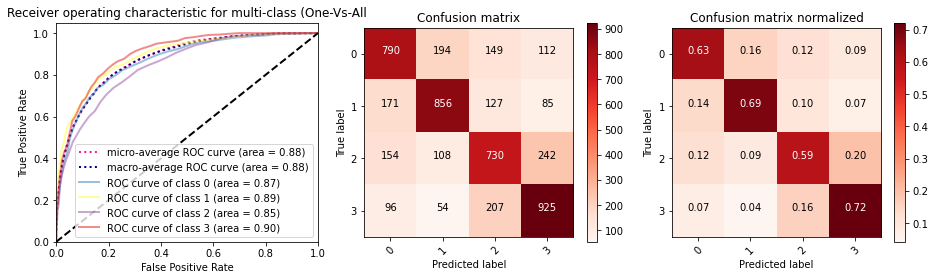

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1245
           1       0.71      0.69      0.70      1239
           2       0.60      0.59      0.60      1234
           3       0.68      0.72      0.70      1282

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



In [ ]:
from plot_metric.functions import MultiClassClassification
mc = MultiClassClassification(y_test,clf.predict_proba(X_test),labels=[0,1,2,3])
plt.figure(figsize=(13,4))
plt.subplot(131)
mc.plot_roc()
plt.subplot(132)
mc.plot_confusion_matrix()
plt.subplot(133)
mc.plot_confusion_matrix(normalize=True)
plt.show()

mc.print_report()

# 2 Advanced solution

In [ ]:
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:
'''identify a numeral in a short sequence'''
def getXy(files,labels_file,cls2label):
  X,y =[],[]
  for file in tqdm(files):
    xi = list()
    fileID = file.split('/')[-1]
    yi = cls2label[list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]]
    if yi > 9:
        continue
    else:
        fs = None
        x, fs = librosa.load(file,sr=fs)
        chroma_stft = librosa.feature.chroma_stft(x, fs) # Chromaticity frequency
        rmse = librosa.feature.rms(x) # Calculate rmse
        spec_cent = librosa.feature.spectral_centroid(x, fs) # Calculate the spectral centroid of each frame of audio signal
        spec_bw = librosa.feature.spectral_bandwidth(x, fs) # Calculate the spectral width of each frame of audio signal
        rolloff = librosa.feature.spectral_rolloff(x, fs) # Spectral Roll-off Spectral Roll-off It is a measure of signal shape.
        zcr = librosa.feature.zero_crossing_rate(x) # Zero Crossing Rate,ZCR refers to the number of times the speech signal passes through the zero point (from positive to negative or from negative to positive) in each frame
        mfcc = librosa.feature.mfcc(x, fs) # Mel frequency cepstral coefficient MFCC is a small group of features (usually about 10-20), which concisely describes the overall shape of the spectrum envelope, which simulates the characteristics of the human voice.
        xi.append(np.mean(chroma_stft))
        xi.append(np.mean(rmse))
        xi.append(np.mean(spec_cent))
        xi.append(np.mean(spec_bw))
        xi.append(np.mean(rolloff))
        xi.append(np.mean(zcr))
        for feature in mfcc:
          xi.append(np.mean(feature))
        X.append(xi)
        y.append(yi)
  return np.array(X),np.array(y)

In [ ]:
models = {
    'svm':SVC(C=10,probability=True,random_state=0),
    'random_forest':RandomForestClassifier(random_state=0),
    'MLP':MLPClassifier(random_state=0),
}

Model fusion

In [ ]:
def StackingMethod(X_train, X_test, y_train, y_test):
    clf1 = models['MLP']
    clf2 = models['svm']
    clf3 = models['random_forest']
    sclf = StackingClassifier(classifiers=[clf1, clf2, clf3],
                              meta_classifier=SVC(probability=True))

    sclf.fit(X_train,y_train)

    # Model test
    predict_results = sclf.predict(X_test)
    print(predict_results)
    print(accuracy_score(predict_results.astype('int'), y_test))


    return sclf

In [ ]:
cls2label = dict(zip(np.sort(labels.loc[:,"digit_label"].drop_duplicates().values),list(range(len(labels.loc[:,"digit_label"].drop_duplicates())))))
cls2label

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 30: 21,
 40: 22,
 50: 23,
 60: 24,
 70: 25,
 80: 26,
 90: 27,
 100: 28,
 1000: 29,
 1000000: 30,
 1000000000: 31}

In [ ]:
X,y = getXy(files,labels,cls2label)


 11%|█         | 2186/20000 [00:15<01:58, 149.84it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
100%|██████████| 20000/20000 [02:33<00:00, 130.47it/s]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_test  = (X_test-mean)/sd

sclf = StackingMethod(X_train,X_test,y_train,y_test)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[9 8 9 ... 6 6 1]
0.5403916768665851


Draw ROC curve and confusion matrix

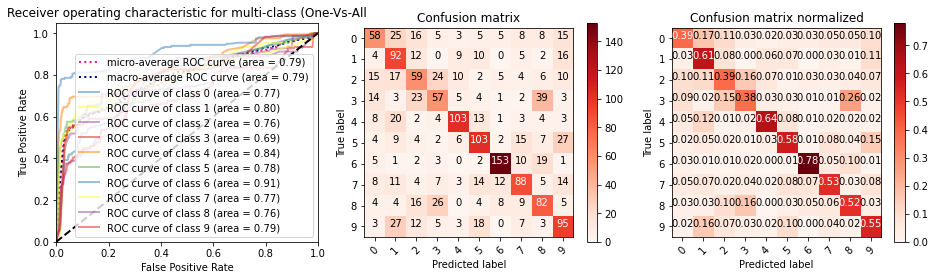

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.47      0.39      0.43       148
           1       0.44      0.61      0.51       150
           2       0.39      0.39      0.39       152
           3       0.43      0.38      0.40       151
           4       0.73      0.64      0.68       161
           5       0.59      0.58      0.58       179
           6       0.82      0.78      0.80       196
           7       0.58      0.53      0.56       166
           8       0.47      0.52      0.49       158
           9       0.50      0.55      0.52       173

    accuracy                           0.54      1634
   macro avg       0.54      0.54      0.54      1634
weighted avg       0.55      0.54      0.55      1634



In [ ]:
from plot_metric.functions import MultiClassClassification
mc = MultiClassClassification(y_test,sclf.predict_proba(X_test),labels=list(range(10)))
plt.figure(figsize=(13,4))
plt.subplot(131)
mc.plot_roc()
plt.subplot(132)
mc.plot_confusion_matrix()
plt.subplot(133)
mc.plot_confusion_matrix(normalize=True)
plt.show()

mc.print_report()

# Conclusion

**Compare the training and validation accuracies:**
Normalization has a certain improvement in prediction training and prediction accuracy